In [165]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
import numpy as np
import random

### Задание 1
Для реализованной модели градиентного бустинга постройте графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделайте выводы о зависимости ошибки от этих параметров.

In [166]:
from sklearn.datasets import load_diabetes

In [167]:
X, y = load_diabetes(return_X_y=True)

In [168]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [169]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже считаются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [170]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ её производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем её также в виде функции — коэффициент 2 можно отбросить.

In [171]:
def bias(y, z):
    return (y - z)

In [172]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [173]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [174]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [175]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 5922.2127783452215
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 5095.755586439804


In [176]:
import matplotlib.pyplot as plt
%matplotlib inline

#### График зависимости ошибки от количества деревьев в ансамбле:

In [177]:
n_trees = np.arange(1, 50, 5)
eta = 0.1

def plot_n_trees_error(n_trees=n_trees, max_depth=3):
    train_errors_list = [] 
    test_errors_list = []
    for i in n_trees:
        tree, train_errors, test_errors = gb_fit(i, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
        train_errors_list.append(train_errors[-1])
        test_errors_list.append(test_errors[-1])
        
    plt.xlabel('Number of trees')
    plt.ylabel('MSE')
    plt.plot(n_trees, train_errors_list, label='train error')
    plt.plot(n_trees, test_errors_list, label='test error')
    plt.legend(loc='upper right')
    plt.show()

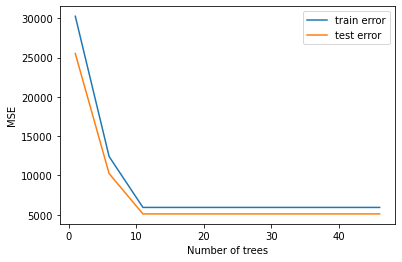

In [178]:
plot_n_trees_error(n_trees=n_trees, max_depth=3)

По графику видно, что при количестве деревьев примерно больше 11, ошибка на обеих выборках снижается уже не так существенно.

#### График зависимости ошибки от максимальной глубины деревьев:

In [179]:
max_depth = np.arange(1, 11)
eta = 0.1

def plot_max_depth_error(n_trees=10, max_depth=max_depth):
    train_errors_list = [] 
    test_errors_list = []
    for i in max_depth:
        tree, train_errors, test_errors = gb_fit(n_trees, i, X_train, X_test, y_train, y_test, coefs, eta)
        train_errors_list.append(train_errors[-1])
        test_errors_list.append(test_errors[-1])
        
    plt.xlabel('Max_depth')
    plt.ylabel('MSE')
    plt.plot(max_depth, train_errors_list, label='train error')
    plt.plot(max_depth, test_errors_list, label='test error')
    plt.legend(loc='upper right')
    plt.show()

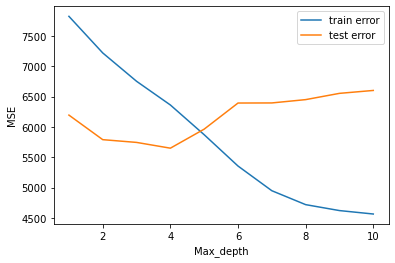

In [180]:
plot_max_depth_error(n_trees=10, max_depth=max_depth)

По графикам можно заметить, что чем больше максимальная глубина деревьев, тем больше переобучается модель: ошибка на трейне падает, а вот на тестовой выборке растет. Важно найти оптимальный баланс по настраиваемым параметрам обучения градиентного бустинга. В данном случае оптимальное значение max_depth около 5.

### Задание 2
Модифицируйте реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки примите равным 0.5. Сравните на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [182]:
def gb_fit_sgd(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, sample_size = 0.5):
    
    # Деревья будем записывать в список
    trees = []
    n_samples = X_train.shape[0]
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        indices = np.random.randint(0, n_samples, size=int(sample_size * n_samples))
        X_train_sgd, y_train_sgd = X_train[indices], y_train[indices]

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train_sgd, y_train_sgd)
            
            # ошибку посчитаем на всей обучающей и тестовой выборке:
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_sgd, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_sgd, bias(y_train_sgd, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [183]:
n_trees = 20
max_depth = 3
eta = 0.1

In [184]:
%%time 
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

CPU times: user 7.37 s, sys: 21.2 ms, total: 7.39 s
Wall time: 7.4 s


In [185]:
%%time
trees_sgd, train_errors_sgd, test_errors_sgd = gb_fit_sgd(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, sample_size = 0.5)

CPU times: user 5.71 s, sys: 17.2 ms, total: 5.73 s
Wall time: 5.74 s


Можно заметить, что стохастический градиентный бустинг работает намного быстрее.

#### График кривых изменения ошибки на тестовой выборке в зависимости от числа итераций

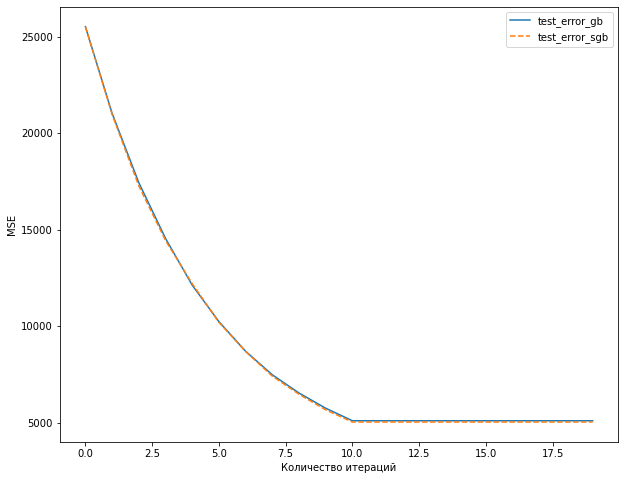

In [186]:
plt.figure(figsize=(10, 8))
plt.plot(range(n_trees), test_errors, label='test_error_gb')
plt.plot(range(n_trees), test_errors_sgd, label='test_error_sgb', linestyle='--')
plt.xlabel('Количество итераций')
plt.ylabel('MSE')
plt.legend()

По графику можно заметить, что с увеличением числа итераций вначале ошибка на тестовой выборке падает при обоих вариантах градиентного спуска(классический GD и SGD). А вот после числа 10 уже значительно не изменяется.